In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression, SelectKBest, f_regression
from bayes_opt import BayesianOptimization
import lightgbm as lgb
from sklearn.utils import resample
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder


from sklearn.metrics import confusion_matrix

random_seed_number=42
np.random.seed(random_seed_number)

In [2]:
df= pd.read_csv('/Users/josephlim/Desktop/Data Science/Capstone Projects/Capstone project- Spotify/Data/Cleaned Data/spotify_data_preprocessed.csv')

In [3]:
df.head()

,popularity,duration_ms,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,0.14,266773,0.429,-7.227,0.0281,0.00239,0.000121,0.2340,0.285,173.372,4
1,0.33,201960,0.659,-5.850,0.0437,0.00450,0.000002,0.3350,0.798,106.965,4
2,0.16,216880,0.556,-5.870,0.0584,0.00958,0.000000,0.2090,0.400,105.143,4
3,0.16,284200,0.949,-4.244,0.0572,0.03020,0.000000,0.0454,0.760,104.504,4
4,0.63,201960,0.659,-5.850,0.0437,0.00450,0.000002,0.3350,0.798,106.965,4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92194 entries, 0 to 92193
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        92194 non-null  float64
 1   duration_ms       92194 non-null  int64  
 2   danceability      92194 non-null  float64
 3   loudness          92194 non-null  float64
 4   speechiness       92194 non-null  float64
 5   acousticness      92194 non-null  float64
 6   instrumentalness  92194 non-null  float64
 7   liveness          92194 non-null  float64
 8   valence           92194 non-null  float64
 9   tempo             92194 non-null  float64
 10  time_signature    92194 non-null  int64  
dtypes: float64(9), int64(2)
memory usage: 7.7 MB


In [5]:
X= df.drop('popularity', axis=1)
y= df['popularity']

Let's split the data into training and testing sets.

In [6]:
X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.3, random_state=12)

In [7]:
df.describe()

,popularity,duration_ms,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,92194.000000,9.219400e+04,92194.000000,92194.000000,92194.00000,92194.000000,92194.000000,92194.000000,92194.000000,92194.000000,92194.000000
mean,0.620856,2.385335e+05,0.600292,-7.563552,0.08614,0.306901,0.063995,0.207626,0.545761,121.392948,3.925559
std,0.162090,1.132078e+05,0.159702,3.763095,0.11218,0.295936,0.205188,0.184344,0.252382,29.337843,0.364847
min,0.060000,6.360000e+03,0.000000,-60.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.510000,1.949470e+05,0.498000,-9.042000,0.03320,0.040300,0.000000,0.096000,0.343000,97.951500,4.000000
50%,0.610000,2.288025e+05,0.611000,-6.816000,0.04480,0.208000,0.000003,0.132000,0.549000,120.379000,4.000000
75%,0.720000,2.687652e+05,0.716000,-5.143000,0.08200,0.530000,0.000607,0.266000,0.758000,139.847750,4.000000
max,1.000000,4.995083e+06,0.991000,2.854000,0.96200,0.996000,1.000000,1.000000,1.000000,220.230000,5.000000


### Dummy Regressor

Let's explore different models we can predict popularity by. A good starting point would be to see how good the mean would be as a predictor. DummyRegressor can do just that.

In [8]:
train_mean= y_train.mean()
train_mean

0.6211939257767103

In [9]:
dumb_reg= DummyRegressor(strategy='mean')

dumb_reg.fit(X_train, y_train)
dumb_reg.score(X_test, y_test)

-4.905220688766754e-05

It comes pretty close for now, but how good is this? We'll see how closely this explains the actual values. There are many metrics we can use to do this. We will try different metrics to choose which one works best for our specific scenario.

## Metrics

**1. Coefficient of determination ($R^{2}$):**
<br> We will make predictions by creating length of size of training set with the single value of the mean.

In [10]:
y_tr_pred_ = train_mean* np.ones(len(y_train))
y_tr_pred_[:5]

array([0.62119393, 0.62119393, 0.62119393, 0.62119393, 0.62119393])

In [11]:
y_tr_pred= dumb_reg.predict(X_train)
y_tr_pred[:5]

array([0.62119393, 0.62119393, 0.62119393, 0.62119393, 0.62119393])

They produce exactly same results. Let's find out ($R^{2}$) score.

In [12]:
r2_score(y_train, y_tr_pred)

0.0

We got $R^{2}$ score of 0 on our training set when we used mean as a predictor. $R^{2}$ explains predictions in terms of the amount of variance. Low $R^{2}$ score suggests small amount of variances explainedn. Let's try this on our test set. 

In [13]:
y_te_pred= train_mean*np.ones(len(y_test))
r2_score(y_test, y_te_pred)

-4.905220688766754e-05

This negative number was expected, because most models perform worse on test sets than on training sets.

**2.Mean Absolute Error (MAE)**
<br>
MAE tells us how much we expect to be off by if we guessed based on the average of known values.

In [14]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(0.1283096229008628, 0.12695481498629366)

MAE on testing set is very slightly worse than on training data, but they are very similar.

**3.Mean Squared Error (MSE)**
<br>Mean squared error is the average of square of errors.

In [15]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(0.02641994124147989, 0.02592975006310815)

While it was pretty obvious from $R^{2}$ score that a simple average would not be the best model, it was worth double (or triple) checking it using different metrics. 

## Initial Models:

Let's build pipelines to simplify processes. 

In [16]:
pipe = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

In [17]:
type(pipe)

sklearn.pipeline.Pipeline

In [18]:
hasattr(pipe, 'fit'), hasattr(pipe, 'predict')

(True, True)

Let's try fitting, making predictions, and evaluating performance using this pipeline.

In [19]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [20]:
y_tr_pred= pipe.predict(X_train)
y_te_pred= pipe.predict(X_test)

In [21]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.05893722425488512, 0.0562299566634179)

Given the number of features, it is possible that I am overfitting. As such, I will limit number of features that get used based on f_regression.

In [22]:
pipe = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [23]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x7ff02ee109d0>)),
                ('linearregression', LinearRegression())])

In [24]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [25]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.05893722425488512, 0.0562299566634179)

In [26]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(0.12555170150316994, 0.12440558470561941)

We see that our model performance got much worse than when we didn't limit features. This was an expected result of limiting feature numbers. Let's try to include more.

In [27]:
pipe10 = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression, k=10),
    LinearRegression()
)

In [28]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [29]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.05893722425488512, 0.0562299566634179)

In [30]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(0.12555170150316994, 0.12440558470561941)

It didn't make too much of a difference. Let's try to use cross-validation to assess model performance.

In [31]:
cv_results= cross_validate(pipe10, X_train, y_train, cv=5)

In [32]:
cv_scores= cv_results['test_score']
cv_scores

array([0.05448415, 0.06167023, 0.06285393, 0.05906513, 0.05470666])

In [33]:
np.mean(cv_scores), np.std(cv_scores)

(0.058556019387911794, 0.0034591100674052832)

We can estimate the variability, or uncertainty of model performance.

In [34]:
np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)

array([0.05, 0.07])

## Linear Regression Model

### GridSearchCV - Linear Regression

In [35]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'selectkbest', 'linearregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [36]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [37]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [38]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7ff02ee109d0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [39]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]


In [40]:
lr_grid_cv.best_params_

{'selectkbest__k': 10}

Text(0.5, 1.0, 'Pipeline mean CV score (error bars +/- 1sd)')

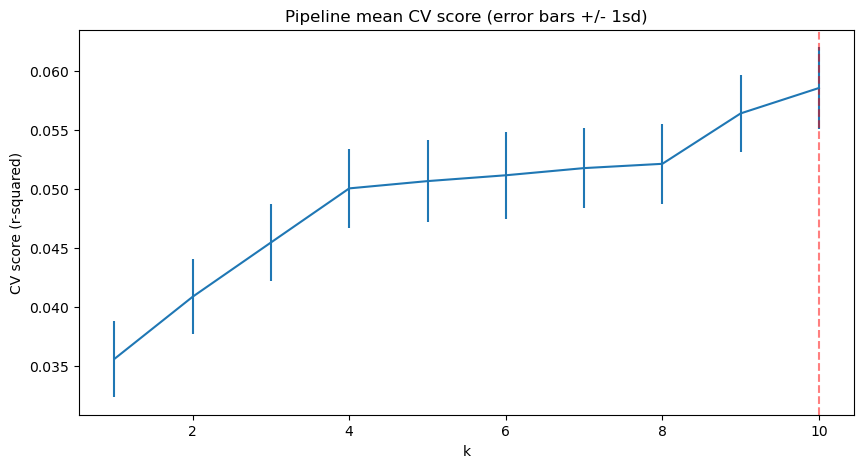

In [41]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)')

In [42]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [43]:
coefs= lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features= X_train.columns[selected]
pd.Series(coefs, index= features).sort_values(ascending= False)

instrumentalness    0.024961
valence             0.015556
liveness            0.010370
duration_ms         0.005414
tempo               0.001156
time_signature      0.001079
speechiness        -0.002219
acousticness       -0.006030
danceability       -0.016478
loudness           -0.017945
dtype: float64

We see that the most positive feature were instrumentalness. This differs from our EDA, which showed preference to non-instrumentalness. Let's try a different model.

## Random Forest Model

In [44]:
RF= RandomForestRegressor(random_state= 47)

In [45]:
rf_default_cv_results= cross_validate(RF, X_train, y_train, cv=5)

In [46]:
rf_cv_scores= rf_default_cv_results['test_score']
rf_cv_scores

array([0.17252583, 0.16152032, 0.17794416, 0.16830315, 0.170554  ])

In [47]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.17016949479007495, 0.005374700071502436)

Random Forest Regression model looks much more promising. Let's see what hyperparameter tuning can do for this model.

#### Random Forest Model- Bayesian Optimization

In [48]:
cv_results.keys()

dict_keys(['fit_time', 'score_time', 'test_score'])

In [49]:
X_train.shape

(64535, 10)

In [50]:
y_train.shape

(64535,)

In [51]:
# def fit_model(n_estimators, min_samples_split, max_depth, max_features):
#     regressor = RandomForestRegressor()
#     params = {
#         'n_estimators':round(n_estimators),
#         'min_samples_split': round(min_samples_split),
#         'max_depth':round(max_depth), 
#         'max_features':round(max_features),
#         'bootstrap': True }

#     return np.mean(cross_validate(regressor, X_train, y_train, scoring='r2', cv=5, return_train_score=True)['test_score'])


In [52]:
# rf_BO = BayesianOptimization(fit_model,{
#         "n_estimators":(300, 2000), 
#         "min_samples_split":(20,100), 
#         "max_depth":(3,7), 
#         "max_features":(5,13), 
#     })

# rf_BO.maximize(n_iter=10, init_points=2)

### Gradient Boosting Model
The performance of Random Forest Model wasn't as good as I hoped. Let's try a gradient boosting model.

#### Gradient Boosting Model- Bayesian Optimization

In [53]:
# def fit_model(n_estimators, min_samples_split, max_depth, max_features):
#     regressor = RandomForestRegressor()
#     params = {
#         'n_estimators':round(n_estimators),
#         'min_samples_split': round(min_samples_split),
#         'max_depth':round(max_depth), 
#         'max_features':round(max_features),
#         'bootstrap': True }

#     return np.mean(cross_validate(regressor, X_train, y_train, scoring='r2', cv=5, return_train_score=True)['test_score'])



def lgb_eval(num_leaves,max_depth,lambda_l2,lambda_l1,min_child_samples, min_data_in_leaf, learning_rate):
    params = {
        "objective" : "regression",
        "metric" : "mse", 
        'is_unbalance': True,
        "num_leaves" : round(num_leaves),
        "max_depth" : round(max_depth),
        "lambda_l2" : float(lambda_l2),
        "lambda_l1" : float(lambda_l1),
        "num_threads" : 20,
        "min_child_samples" : round(min_child_samples),
        'min_data_in_leaf': round(min_data_in_leaf),
        "learning_rate" : float(learning_rate),
        "subsample_freq" : 5,
        "bagging_seed" : 42,
        "verbosity" : -1,
    }
    
    regressor= lgb.LGBMRegressor()

    
    cv_results= cross_validate(regressor,X_train, y_train, cv=5, scoring='r2',return_train_score=True)
    
    return np.mean(cross_validate(regressor, X_train, y_train, scoring='r2', cv=5, return_train_score=True)['test_score'])


lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (25, 4000),
                                                'max_depth': (5, 63),
                                                'lambda_l2': (0.0, 0.5),
                                                'lambda_l1': (0.0, 0.5),
                                                'min_child_samples': (50, 10000),
                                                'min_data_in_leaf': (100, 2000),
                                                "learning_rate": (0.03, 0.5)
                                                })

lgbBO.maximize(n_iter=10, init_points=2)

|   iter    |  target   | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_da... | num_le... |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.1509    | 0.1353    | 0.1437    | 0.3025    | 46.96     | 2.139e+03 | 1.734e+03 | 615.0     |
| 2         | 0.1509    | 0.179     | 0.0404    | 0.2163    | 21.33     | 427.8     | 614.2     | 203.5     |
| 3         | 0.1509    | 0.419     | 0.052     | 0.04153   | 26.73     | 9.921e+03 | 145.9     | 3.992e+03 |
| 4         | 0.1509    | 0.4011    | 0.1423    | 0.2746    | 61.11     | 177.9     | 1.844e+03 | 3.972e+03 |
| 5         | 0.1509    | 0.1853    | 0.1044    | 0.4527    | 39.29     | 9.996e+03 | 1.582e+03 | 41.54     |
| 6         | 0.1509    | 0.0651    | 0.3827    | 0.03833   | 29.66     | 9.75e+03  | 1.46e+03  | 2.045e+03 |
| 7         | 0.1509    | 0.4289    | 0.0747    | 0.1893    | 52.32     | 3.217e+03 | 758.1     | 2.459e+03 |
| 8       

Our prediction actually worsened. For now, our best bet is Random Forest regression model. However, I'm still not too excited about our current model performance. Perhaps we should try our hands at classification models.

### Classifications
We'll try to predict songs' popularities by categorizing popularities(into "high","mid","low"), and classifying songs into those categories.

In [ ]:
pd.cut(df['popularity'], bins=3)

In [ ]:
labels=['low','medium', 'high']
df['popularity']= pd.cut(df['popularity'], bins=3, labels=labels, right=True)

In [ ]:
df.popularity.value_counts()

The dataset is unbalanced. This is intuitive, because there aren't as many popular songs as there are non-popular songs (otherwise, there will be much more financial stability in music industry!). However,imbalance in dataset will tamper with the accuracy of our model. One way to counteract this is by upsampling songs with high popularity.  We will then perform K-Nearest Neighbor classification, because they are good at handling noisy data. 

#### Up-sampling songs with "high" and "low" popularity

In [ ]:
df_high= df[df.popularity=='high']
df_mid= df[df.popularity=='medium']
df_low= df[df.popularity=='low']

df_low_upsampled= resample(df_low, replace=True, n_samples= 57662, random_state=42)
df_high_upsampled= resample(df_high, replace=True, n_samples=57662, random_state=42)


list_df_upsampled=[df_high_upsampled, df_mid, df_low_upsampled]
df_upsampled= pd.concat(list_df_upsampled)

In [ ]:
df_upsampled.popularity.value_counts()

In [ ]:
X_up= df_upsampled.drop('popularity', axis=1)
y_up= df_upsampled['popularity']

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X_up, y_up, random_state= 42, test_size=0.3)

#### Testing Different Classification Models

**KNN Classifier** 

In [ ]:
KNN= KNeighborsClassifier()

KNN.fit(X_train, y_train)

y_pred_classification= KNN.predict(X_test)
print(accuracy_score(y_test, y_pred_classification))

WOW! This is a huge improvement (though it probably is overfitting). Let's try Random Forest Classification.

**Random Forest Classifier**

In [ ]:
scaler=StandardScaler()
RFC= RandomForestClassifier(random_state= 47)

RFC.fit(X_train, y_train)
y_rfc_pred= RFC.predict(X_test)
print(accuracy_score(y_test, y_rfc_pred))

Clearly, Random Forest Classifier performs best for our case. Let's use this model. Before fully delving into this model though, let's check for feature importance to see which features are more relevant for our task.

**Feature Importances**

In [ ]:
importances= pd.Series(data= RFC.feature_importances_, index=X_train.columns)
importances_sorted= importances.sort_values()

importances_sorted.plot(kind='barh', color='blue')
plt.title('Feature Importances')
plt.show()

We see that loudness plays and duration plays the biggest role in predicting popularity. We then see that energy, valence, speechiness, acousticness, danceability, tempo, and liveness, in that order, influence our predictions.

#### Random Forest Classification- Bayesian Optimization

In [ ]:
def fit_model(n_estimators,min_samples_split,max_depth, max_features):
    scaler= StandardScaler()
    RFC= RandomForestClassifier(random_state= 42) 

    params = {
        "n_estimators":round(n_estimators), 
        "min_samples_split":round(min_samples_split), 
        "max_depth": round(max_depth),
        "max_features":round(max_features), 
        "bootstrap": True
    }
    cv_results= cross_validate(RFC, X_train, y_train, cv=5, scoring='accuracy')

    return np.mean(cross_validate(RFC, X_train, y_train, scoring='accuracy', cv=5)['test_score'])

In [ ]:
rf_BO = BayesianOptimization(fit_model,{
        "n_estimators":(300, 2000), 
        "min_samples_split":(20,100), 
        "max_depth":(3,7), 
        "max_features":(5,13), 
    })

rf_BO.maximize(n_iter=10, init_points=2)

In [ ]:
rf_BO.max

Through hyperparameter tuning, we learned that the model can expect target score of 0.86. This score is reasonable, as the model is expected to perform better on training set. However, our current target score is still great. Let's use confusion matrix to further evaluate our model.

### Confusion Matrix

In [ ]:
cmat = confusion_matrix(y_test, y_rfc_pred)
#print(cmat)
print('TP - True Negative {}'.format(cmat[0,0]))
print('FP - Flase Positive {}'.format(cmat[0,1]))
print('FN - False Negative {}'.format(cmat[1,0]))
print('TP - True Positive {}'.format(cmat[1,1]))
print('Accuracy Score: {}'.format(np.divide(np.sum([cmat[0,0], cmat[1,1], cmat[2,2]]), np.sum(cmat)))) 
print('Misclassification Rate: {}'.format(np.divide(np.sum([cmat[1,0], cmat[0,1], cmat[0,2], cmat[2,0], cmat[1,2], cmat[2,1]]), np.sum(cmat))))

An accuracy score of 89% is great! We came a long way from our linear regression model. 